### Metric methods for a regression problem

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.cluster import AgglomerativeClustering,KMeans,SpectralClustering
from sklearn.metrics import mean_absolute_error,mean_squared_error
from scipy import stats
from collections import OrderedDict
%matplotlib inline

Visualization

In [2]:
#visualization method
def visualize(X,Y,X_test,Y_test,Y_pred=[],scatter= False):
    plt.figure(figsize=(12,6))
    
    plt.plot(X,Y,'ro',label='train points')
    plt.plot(X_test,Y_test,'go',label='test points')
    
    if Y_pred:
        if scatter:
            plt.plot(X_test,Y_pred,'bs',label = 'regression points')
        else:
            plt.plot(sorted(X_test),sorted(Y_pred),'#222222',label = 'regression line')
    plt.legend()
    #plt.axis([-2.25, 2.25, -0.25, 1.25])
    plt.show()

Reading data from csv file

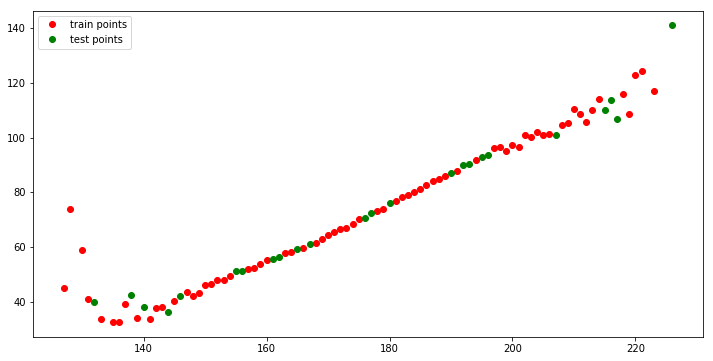

In [15]:
visualize(X_tr,Y_tr,X_t,Y_t)

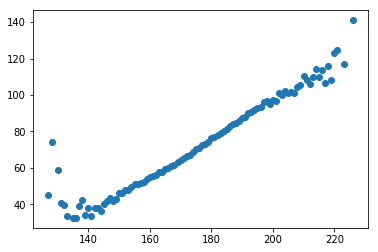

In [13]:
np.random.seed(40)
temp = pd.read_csv("athlete_events.csv")
t = temp[['Height','Weight']].copy()
#t.dropna(axis=0,inplace=True)
q = (t.groupby('Height').mean())
X = q.reset_index().values
plt.scatter(X[:,0],X[:,1])

train,test = train_test_split(X)
X_tr,X_t = train[:,0],test[:,0]
Y_tr,Y_t = train[:,1],test[:,1]

### Naive approach - KNN for regression

KNN and Parzen windows for a regression problem with inverted average weights as a prediction function

In [4]:
class KNN_regression(object):
    """
    KNN for regression
    
    Arguments:
    ---------
    k -- number of nearest neighbours
    X -- input matrix
    """
    def euclidean_dist(self,x,y):
        """
        Euclidean distance between points x and y
        """
        if type(x)==np.float64:
            return (((y-x)**2)**0.5)
        return sum((y[i]-x[i])**2 for i in range(len(x)))**0.5
    
    def manhattan_dist(self,x,y):
        """
        Manhattan distance between points x and y
        """
        if type(x)==np.float64:
            return (abs(x-y))
        return sum(abs(x[i]-y[i]) for i in range(len(x)))

    
    def __init__(self,k=None, X_train=None, X_test = None, Y_train = None, Y_test = None, window_width = None, inverted_weights= False):
        self.X_train, self.X_test  = X_train, X_test
        self.Y_train, self.Y_test  = Y_train, Y_test
        self.inverted_weights = inverted_weights
        if k is not None:
            self.k = k
            self.parzen = False
        else:#using Parzen window  
            self.w = window_width
            self.parzen = True
      
        
    def get_Neighbours(self,point):
        """
        Arguments:
            point -- chosen point from X_test
        Returns:
            list of k closest neighbours [[distance,index],...]
        """
        distances = {self.euclidean_dist(self.X_train[i],point):i for i in range(len(self.X_train))}
        distances = OrderedDict(sorted(distances.items()))
        if self.parzen:
            i = sum(1 if d<=self.w else 0 for d in list(distances.values()))
            return list(distances.items())[:i]
        else:
            k_nearest = list(distances.items())[:self.k]
            return (k_nearest)

        
    def get_Weights(self,neighbours):
        """
        Arguments:
        ---------
        neighbours -- list of k closest neighbours [[distance,index],...]
        Returns:
        ---------
        list of inverted weights - highest score for the closest point
        """
        distances = [row[1] for row in neighbours]
        inverted_distances = [sum(distances)/(d+1) for d in distances]
        return [d/sum(inverted_distances) for d in inverted_distances]
    
    def predict(self):
        prediction = []
        for point in self.X_test:
            #get neighbours
            neighbours = self.get_Neighbours(point)
            #calculate weight based on proximity of each point
            if self.inverted_weights:
                weights = self.get_Weights(neighbours)
                #predict price based on their values
                prediction.append(self.predict_weighted_average(neighbours,weights))
            else:
                prediction.append(self.predict_average(neighbours))
            
        self.pred = np.array(prediction)
        return self.pred
    
    def predict_average(self, neighbours):
        """
        Arguments:
            neighbours -- list of k closest neighbours [[distance,index],...]
        Returns:
            prediction based on average
        """
        indices = [row[1] for row in neighbours]
        values = self.Y_train[indices]
        return np.mean(values)
    
    def predict_weighted_average(self,neighbours,weights):
        """
        Arguments:
            neighbours -- list of k closest neighbours [[distance,index],...]
            weights -- list of inverted weights
        Returns:
            prediction based on weighted average
        """
        indices = [row[1] for row in neighbours]
        values = self.Y_train[indices]
        
        return np.dot(values,weights)

    
    def calculate_error(self,param="squared"):
        if param=="squared":
            return mean_squared_error(self.Y_test,self.pred)
        else:
            return mean_absolute_error(self.Y_test,self.pred)
    
    
    def set_width(self, w):
        self.w = w
    
    def set_k(self,k):
        self.k = k
        
    def get_X_test(self):
        return self.X_test
    def get_pred(self):
        return self.pred

### Generating weights:

Let's say we have 3 neighbours for a certain point P.
$$totalDistance = \sum\limits_{i=0}^n{dist_i}$$

| dist(p,p1) | dist(p,p2) | dist(p,p3) | totalDistance|
| --- | --- | --- | --- |
| 0.5 | 1.5 | 4.0 | 6.0 |

Let's say we want to assign average weights based on their 'share in a total distance':

| w1 | w2 | w3 | $\sum$|
| --- | --- | --- | --- |
| 0.083 | 0.25 | 0.667 | 1.0 |

As we may see, the furthest point has the most weight.
But our goal is to make closest points the most important.
To achieve that we will use inverted average weighting

<center>Let's calculate inverted weights: <font size=4>$ w_i = \frac{totalDistance}{dist(p,p_i)+1}$</font></center>

| id1 | id2 | id3 | $\sum$|
| --- | --- | --- | ---|
| 4.0 | 2.4 | 1.2 | 7.6|

The new shares will be:

| iw1 | iw2 | iw3 | $\sum$ |
| --- | --- | --- | --- |
| 0.526 | 0.316 | 0.158 | 1.0 |


KNN without inverted weights
35.86810027316404
2.9423084364244203


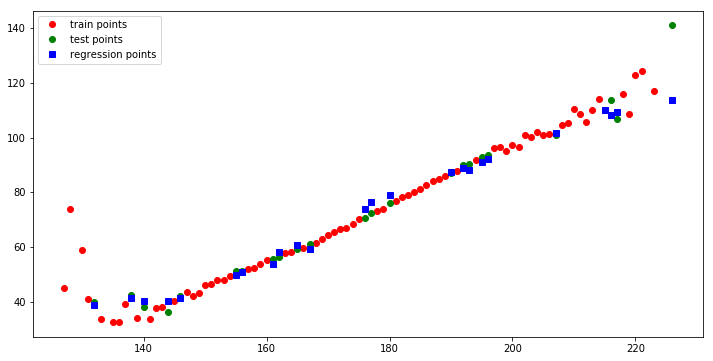

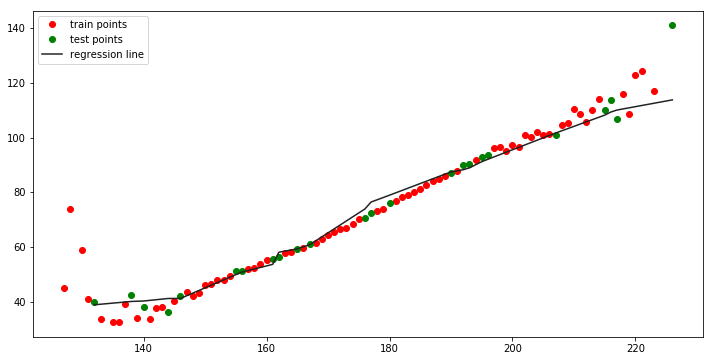

In [16]:
model = KNN_regression(10,X_train=X_tr,X_test=X_t,Y_train=Y_tr,Y_test=Y_t)
pr = model.predict()

print("KNN without inverted weights")
print(model.calculate_error("squared"))
print(model.calculate_error("absolute"))

visualize(X_tr,Y_tr,X_t,Y_t,list(pr),True)
visualize(X_tr,Y_tr,X_t,Y_t,list(pr))

Using inverted weights
53.3928350144247
4.718820180169873


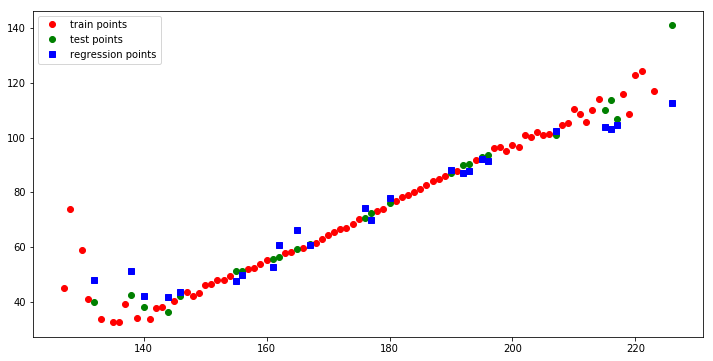

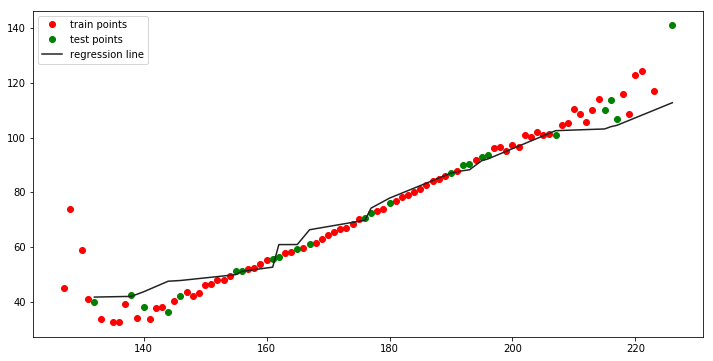

In [17]:
#whts = model.get_Weights(nbrs)
#indices = [row[1] for row in nbrs]
#m = X_tr[indices][:,2]
#np.dot(m,whts)


model = KNN_regression(10,X_train=X_tr,X_test=X_t,Y_train=Y_tr,Y_test=Y_t,inverted_weights=True)
pr = model.predict()

print("Using inverted weights")
print(model.calculate_error("squared"))
print(model.calculate_error("absolute"))
visualize(X_tr,Y_tr,X_t,Y_t,list(pr),True)
visualize(X_tr,Y_tr,X_t,Y_t,list(pr))

Parzen regression
29.536358052458894
2.839608617340959


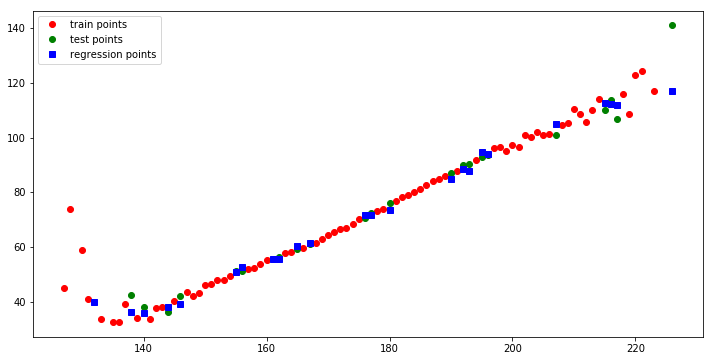

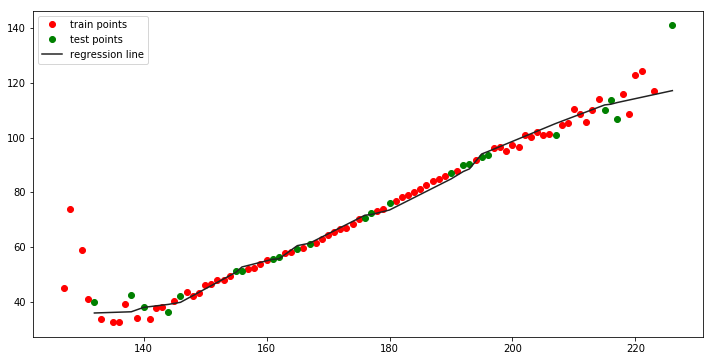

In [18]:
model = KNN_regression(X_train=X_tr,X_test=X_t,Y_train=Y_tr,Y_test = Y_t, window_width=5.0)
pr = model.predict()
print("Parzen regression")
print(model.calculate_error())
print(model.calculate_error("absolute"))
visualize(X_tr,Y_tr,X_t,Y_t,list(pr),True)
visualize(X_tr,Y_tr,X_t,Y_t,list(pr))

In [20]:
accuracy_mse_knn, accuracy_mse_knn_w,accuracy_mse_parzen = [],[],[]
model = KNN_regression(1,X_train=X_tr,X_test=X_t,Y_train=Y_tr,Y_test=Y_t)
for i in range(1,20):
    model.set_k(i)
    pr = model.predict()
    accuracy_mse_knn.append(model.calculate_error('absolute'))

    
model = KNN_regression(1,X_train=X_tr,X_test=X_t,Y_train=Y_tr,Y_test=Y_t,inverted_weights=True)
for i in range(1,20):
    model.set_k(i)
    pr = model.predict()
    accuracy_mse_knn_w.append(model.calculate_error('absolute'))


model = KNN_regression(X_train=X_tr,X_test=X_t,Y_train=Y_tr,Y_test = Y_t, window_width=1.0)
for i in range(5,20):
    model.set_width(float(i))
    pr = model.predict()
    accuracy_mse_parzen.append(model.calculate_error('absolute'))

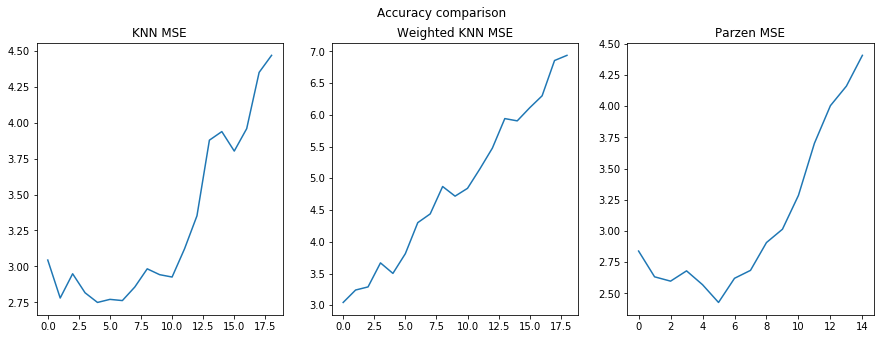

In [21]:
plt.figure(figsize=(15,5))

plt.subplot(131)
plt.title("KNN MSE")
plt.plot(accuracy_mse_knn)

plt.subplot(132)
plt.title("Weighted KNN MSE")
plt.plot(accuracy_mse_knn_w)

plt.subplot(133)
plt.title("Parzen MSE")
plt.plot(accuracy_mse_parzen)

plt.suptitle("Accuracy comparison")
plt.show()

### Kernel Regression

<font size=5>$ f(x):= \frac {\sum_{i=1}^n K_{\lambda}(x_0,x_i)y_i}{\sum_{i=1}^n K_{\lambda}(x_0,x_i)} $</font>

In [10]:
class Kernel:
    """
    Nadaraya-Watson weighted average regressor using kernel functions
    """
    def euclidean_dist(self,x,y):
        """
        Euclidean distance between points x and y
        """
        if type(x)==np.float64:
            return (((y-x)**2)**0.5)#1 dim
        return sum((y[i]-x[i])**2 for i in range(len(x)))**0.5 #2 dim

    def __init__(self,X_train,Y_train,X_test,Y_test, params, lam = 0.2):
        
        self.X_train, self.X_test = X_train, X_test
        self.Y_train, self.Y_test = Y_train, Y_test
        self.lam = lam
        if params:
            self.params = params
        else:
            print("wrong set of parameters")
        
    def kernel(self,x0,x1):
        """
        Arguments:
        ----------
        x0 -- test point
        x1 -- train point
        Returns:
        -------
        value of Kernel function for a specific pair and parameter
        """
        u = round(self.euclidean_dist(x0,x1),5)/self.lam
        self.u.append(u)
       # print(u,x0,x1)
        if u>1:
            return 0
        else:
            if self.current_param == "parabolic": #Epanenchikov
                return 0.75 * (1-u**2)
            
            elif self.current_param == "quartic":#Біквадратне
                return 15*((1-u**2)**2)/16

            elif self.current_param == "gaussian":
                return np.exp(-0.5 * u**2) / ((2 * np.pi)**0.5)
        
            elif self.current_param == "cosine":#Косинусоидальное
                return np.pi/4 * np.cos(u*np.pi/2)
            
            elif self.current_param == "triangle":
                return 1-abs(u)
            
            elif self.current_param == "uniform":
                return 0.5
            return 0.5  
        
    def predict(self,param):
        self.u = []
        
        if param.lower() in self.params:
            self.current_param = param
        else:
            self.current_param = param[0].lower()
        
        prediction = []
        
        for point in self.X_test:
            K =[self.kernel(x,point) for x in self.X_train]#values of a kernel function
            prediction.append(sum(k*y for k,y in zip(K,self.Y_train))/sum(K))                      
        self.pred = prediction
        
        return self.pred
        
    
    def calculate_error(self,param="squared"):
        if param=="squared":
            return mean_squared_error(self.Y_test,self.pred)
        else:
            return mean_absolute_error(self.Y_test,self.pred)
        
    def setParam(self,param):
        self.current_param=param
        
    def set_lam(self,l):
        self.lam=l
    
    def getDistances(self,point):
        return [round(self.euclidean_dist(x,point),5) for x in self.X_train]
    def getU(self):
        return self.u

Nadaraya-Watson Kernel regressor
25.27579324478192
2.5662463209868327


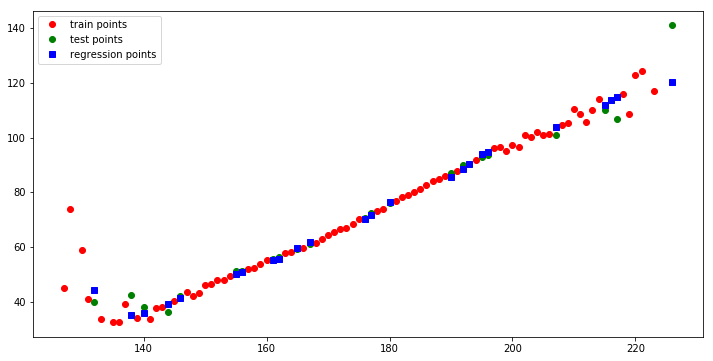

In [22]:
parameters = ["parabolic","quartic","gaussian"]
k = Kernel(X_tr,Y_tr,X_t,Y_t,parameters,lam=5)
p = k.predict("gaussian")

print("Nadaraya-Watson Kernel regressor")
print(k.calculate_error("squared"))
print(k.calculate_error("absolute"))

visualize(X_tr,Y_tr,X_t,Y_t,list(p),True)

In [27]:
model = Kernel(X_tr,Y_tr,X_t,Y_t,parameters,lam=2)
def acc_NW(model,m,n,kernel="parabolic",error="absolute"):
    """
        m,n - range for lambda
    """
    acc = []
    for i in range(m,n):
        model.set_lam(i)
        pr = model.predict(kernel)
        acc.append(model.calculate_error(error))
    return acc

accuracy_nadarayaW_Epanenchikov = acc_NW(model,4,25,"parabolic") 
accuracy_nadarayaW_Gaussian = acc_NW(model,4,25,"gaussian")
accuracy_nadarayaW_quartic = acc_NW(model,4,25,"quartic")


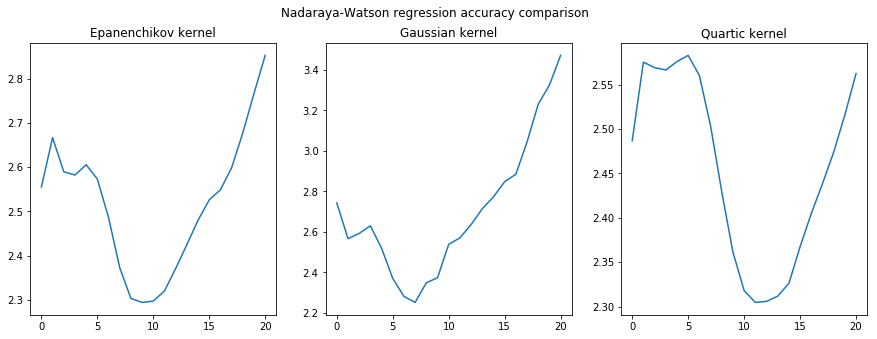

In [28]:
plt.figure(figsize=(15,5))

plt.subplot(131)
plt.title("Epanenchikov kernel")
plt.plot(accuracy_nadarayaW_Epanenchikov)

plt.subplot(132)
plt.title("Gaussian kernel")
plt.plot(accuracy_nadarayaW_Gaussian)

plt.subplot(133)
plt.title("Quartic kernel")
plt.plot(accuracy_nadarayaW_quartic)

plt.suptitle("Nadaraya-Watson regression accuracy comparison")
plt.show()

### LOWESS algorithm

In [ ]:
class LOWESS(Kernel):
    """
    
    """
    
    def __init__(self,X_train,Y_train,X_test,Y_test,params):
        
        super().__init__(X_train,Y_train,X_test,Y_test,params)
        self.coeffs = np.ones(self.X_train.shape)
        self.N = len(X_train)
    
    
    def smooth(self,it,param):
        self.u = []
        if param in self.params:
            self.setParam(param)
        else:
            self.setParam(self.params[0])
            
        for i in range(it):
            self.A = [sum(self.coeffs[i]*self.Y_train[i]*self.kernel(self.X_train[i],self.X_train[j]) for i in range(self.N) if i!=j)/sum(self.coeffs[i]*self.kernel(self.X_train[i],self.X_train[j]) for i in range(self.N)) for j in range(self.N)]
            self.coeffs = np.array([self.kernel(self.A[i],self.Y_train[i]) for i in range(self.N)])
        return "Success"
    
    
    def calculate_accuracy(self,param="squared"):
        if param=="squared":
            return mean_squared_error(self.X_test[:,2],self.pred)
        else:
            return mean_absolute_error(self.X_test[:,2],self.pred)


In [ ]:
l = LOWESS(X_tr,Y_tr,X_t,Y_t,parameters)

In [ ]:
l.smooth(3,"uniform")